In [118]:
# Based on the original implemenation in a tutrial by Jason Brownlee on Recurrent Neural Networks
%matplotlib inline

from __future__ import print_function
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow import keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.keras import backend as k


plt.style.use('ggplot')



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8962205123085112713
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22881945600
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2101562495921823217
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [119]:
#fetch data from the Environment Agency API
import requests # library to handle requests
import json #json library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
StationID = ""
#set up api Calls

root = "http://environment.data.gov.uk/flood-monitoring" #This is the basis of all API requests for monitoring data

raingaugesRequest = "/id/stations" # filters to use are: parameter=p, parameterName=pn, qualifier=q, town=t, catchmentName=c, riverName=r, RLOIid=r, lat=y&long=x&dist=r, search=x (text in label), status=s, type=t
StationParams ="?riverName=River Dove"

MeasuresRequest =  "/id/stations/"+StationID+"/measures" #this lists the measures available at a given monitoring site. MUST HAVE SET StationID VALUE BEFORE CALLING 

ReadingsRequest = "/id/stations/"+StationID+"/readings" # latest, today, date=d, startdate=d1&enddate=d2, since=dt, _view=full, _sorted






In [120]:
#get the list of river dove raingauges 
Measurementraingauges = requests.get(root+raingaugesRequest+StationParams).json()
#content = content = json.loads(Measurementraingauges.text)
df_stations = pd.json_normalize(Measurementraingauges, "items")
df_stations['deltalat']=df_stations['lat'] - 53.055864
df_stations['deltalong']=df_stations['long'] -1.78227
df_stations['dist'] = ((df_stations['deltalat'] ** 2) + (df_stations['deltalong'] ** 2 )) ** 0.5
df_stations.fillna('0',inplace=True)
df_stations.head(20)

,@id,RLOIid,catchmentName,dateOpened,easting,label,lat,long,measures,northing,...,riverName,stageScale,stationReference,status,town,wiskiID,gridReference,deltalat,deltalong,dist
0,http://environment.data.gov.uk/flood-monitorin...,2150,Dove,2000-10-19,416308,Aston Bridge,52.877141,-1.759128,[{'@id': 'http://environment.data.gov.uk/flood...,331103,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4124,http://environment.data.gov.uk/flood-monitorin...,Sudbury,4124,0,-0.178723,-3.541398,3.545905
1,http://environment.data.gov.uk/flood-monitorin...,8241,Don and Rother,1998-08-12,434973,Worsbrough,53.526193,-1.473913,[{'@id': 'http://environment.data.gov.uk/flood...,403411,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,F0815,http://environment.data.gov.uk/flood-monitorin...,Worsbrough,F0815,SE3497303411,0.470329,-3.256183,3.289975
2,http://environment.data.gov.uk/flood-monitorin...,2107,Dove,1961-07-28,423750,Marston on Dove,52.855534,-1.648727,[{'@id': 'http://environment.data.gov.uk/flood...,328730,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4018,http://environment.data.gov.uk/flood-monitorin...,Rolleston On Dove,4018,0,-0.200330,-3.430997,3.436840
3,http://environment.data.gov.uk/flood-monitorin...,2119,Dove,1969-06-03,414690,Izaak Walton,53.055864,-1.782274,[{'@id': 'http://environment.data.gov.uk/flood...,350980,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4046,http://environment.data.gov.uk/flood-monitorin...,Ilam,4046,0,0.000000,-3.564544,3.564544
4,http://environment.data.gov.uk/flood-monitorin...,8117,Derwent,1972-01-17,470500,Kirkby Mills,54.260305,-0.919219,[{'@id': 'http://environment.data.gov.uk/flood...,485500,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,F2560,http://environment.data.gov.uk/flood-monitorin...,Kirkby Mills,F2560,0,1.204441,-2.701489,2.957824
5,http://environment.data.gov.uk/flood-monitorin...,2133,Dove,1985-12-27,411200,Doveridge,52.902503,-1.834928,[{'@id': 'http://environment.data.gov.uk/flood...,333910,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4078,http://environment.data.gov.uk/flood-monitorin...,Doveridge,4078,0,-0.153361,-3.617198,3.620448
6,http://environment.data.gov.uk/flood-monitorin...,2101,Dove,1953-04-15,411250,Rocester,52.954550,-1.833986,[{'@id': 'http://environment.data.gov.uk/flood...,339700,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4008,http://environment.data.gov.uk/flood-monitorin...,Rocester,4008,0,-0.101314,-3.616256,3.617675
7,http://environment.data.gov.uk/flood-monitorin...,9070,Dove,2000-11-01,416049,Mayfield,52.999734,-1.762306,[{'@id': 'http://environment.data.gov.uk/flood...,344740,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4122,http://environment.data.gov.uk/flood-monitorin...,Mayfield,4122,SK16054474,-0.056130,-3.544576,3.545020
8,http://environment.data.gov.uk/flood-monitorin...,9059,Dove,2000-11-01,421709,Hatton,52.861553,-1.678994,[{'@id': 'http://environment.data.gov.uk/flood...,329390,...,River Dove,http://environment.data.gov.uk/flood-monitorin...,4898,http://environment.data.gov.uk/flood-monitorin...,Hatton,4898,SK 2171 2939,-0.194311,-3.461264,3.466714


In [121]:
#get the list of raingaues closest to Izaak Walton station

Raingauges= requests.get("http://environment.data.gov.uk/flood-monitoring/id/stations?parameter=rainfall").json()
df_raingauges = pd.json_normalize(Raingauges, "items")
df_raingauges['deltalat']=df_raingauges['lat'] - 53.055864 #set value explicitly here, too lazy to pull from dataframe
df_raingauges['deltalong']=df_raingauges['long'] - -1.78227  #set value explicitly here, too lazy to pull from dataframe
df_raingauges['dist'] = ((df_raingauges['deltalat'] ** 2) + (df_raingauges['deltalong'] ** 2 )) ** 0.5 #pythagorian calculation based on lat and long, i know this isn't neccessarily in keeping with projections, but it is still relative. 
df_raingauges.sort_values('dist', inplace=True)
df_raingauges.drop(['riverName','stageScale','datumOffset'], axis =1, inplace = True)
df_raingauges.replace(np.nan,0)
df_raingauges.fillna('0',inplace=True)
df_raingauges.head(20)


,@id,RLOIid,catchmentName,dateOpened,easting,gridReference,label,lat,long,measures,northing,notation,stationReference,status,town,wiskiID,deltalat,deltalong,dist
838,http://environment.data.gov.uk/flood-monitorin...,0,0,0,418650.0,SK186476,Rainfall station,53.025808,-1.723384,[{'@id': 'http://environment.data.gov.uk/flood...,347650.0,3323,3323,0,0,0,-0.030056,0.058886,0.066113
328,http://environment.data.gov.uk/flood-monitorin...,0,0,0,422950.0,SK229552,Rainfall station,53.093957,-1.658736,[{'@id': 'http://environment.data.gov.uk/flood...,355250.0,3576,3576,0,0,0,0.038093,0.123534,0.129274
201,http://environment.data.gov.uk/flood-monitorin...,0,0,0,405850.0,SK058480,Rainfall station,53.029694,-1.914215,[{'@id': 'http://environment.data.gov.uk/flood...,348050.0,3570,3570,0,0,0,-0.02617,-0.131945,0.134515
195,http://environment.data.gov.uk/flood-monitorin...,0,0,0,424150.0,SK241500,Rainfall station,53.047163,-1.641206,[{'@id': 'http://environment.data.gov.uk/flood...,350050.0,3580,3580,0,0,0,-0.008701,0.141064,0.141332
578,http://environment.data.gov.uk/flood-monitorin...,0,0,0,409450.0,SK094338,Rainfall station,52.901997,-1.860947,[{'@id': 'http://environment.data.gov.uk/flood...,333850.0,3349,3349,0,0,0,-0.153867,-0.078677,0.172815
6,http://environment.data.gov.uk/flood-monitorin...,0,0,0,406650.0,SK066666,Rainfall station,53.196879,-1.901908,[{'@id': 'http://environment.data.gov.uk/flood...,366650.0,3307,3307,0,0,0,0.141015,-0.119638,0.184928
384,http://environment.data.gov.uk/flood-monitorin...,0,0,0,420050.0,SK200698,Rainfall station,53.22531,-1.701132,[{'@id': 'http://environment.data.gov.uk/flood...,369850.0,3616,3616,0,0,0,0.169446,0.081138,0.18787
42,http://environment.data.gov.uk/flood-monitorin...,0,0,0,401350.0,SK013466,Rainfall station,53.017139,-1.981319,[{'@id': 'http://environment.data.gov.uk/flood...,346650.0,3173,3173,0,0,0,-0.038725,-0.199049,0.202781
123,http://environment.data.gov.uk/flood-monitorin...,0,0,0,428450.0,SK284402,Rainfall station,52.958861,-1.577925,[{'@id': 'http://environment.data.gov.uk/flood...,340250.0,3588,3588,0,0,0,-0.097003,0.204345,0.2262
496,http://environment.data.gov.uk/flood-monitorin...,0,0,0,399350.0,SJ993583,Rainfall station,53.122311,-2.011159,[{'@id': 'http://environment.data.gov.uk/flood...,358350.0,3110,3110,0,0,0,0.066447,-0.228889,0.238339


In [122]:
import folium 

map_upperdove = folium.Map(location=[53.055864, -1.7822], zoom_start=11)
for lat, lng, stationReference in zip(df_raingauges['lat'], df_raingauges['long'], df_raingauges['stationReference'] ):
    label = '{}, {}, {}'.format(stationReference, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_upperdove)  

for lat, lng, stationReference in zip(df_stations['lat'], df_stations['long'], df_stations['label'] ):
    label = '{}, {}, {}'.format(stationReference, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#cc3186',
        fill_opacity=0.7,
        parse_html=False).add_to(map_upperdove)  


map_upperdove

In [123]:
# From map the upstream raingage station reference is 3307. For a blended picture we will include 3323 at ashbourne and 3570 at whiston as they are closer and will support with rainfall data spatial variation

StationID ="3323"
ReadingsRequest = "/id/stations/"+StationID+"/readings?_limit=100000" # latest, today, date=d, startdate=d1&enddate=d2, since=dt, _view=full, _sorted
rain3323 = Raingauges= requests.get(root+ReadingsRequest).json()
df_3323r = pd.json_normalize(rain3323, "items")
df_3323r['dateTime'] = pd.to_datetime(df_3323r['dateTime'])
df_3323r.drop(['@id','measure'], axis =1, inplace = True)
#df_3323r.head()

StationID ="3307"
ReadingsRequest = "/id/stations/"+StationID+"/readings?_limit=100000" # latest, today, date=d, startdate=d1&enddate=d2, since=dt, _view=full, _sorted
rain3307 = Raingauges= requests.get(root+ReadingsRequest).json()
df_3307r = pd.json_normalize(rain3307, "items")
df_3307r['dateTime'] = pd.to_datetime(df_3307r['dateTime'])
df_3307r.drop(['@id','measure'], axis =1, inplace = True)


StationID ="3570"
ReadingsRequest = "/id/stations/"+StationID+"/readings?_limit=100000" # latest, today, date=d, startdate=d1&enddate=d2, since=dt, _view=full, _sorted
rain3570 = Raingauges= requests.get(root+ReadingsRequest).json()
df_3570r = pd.json_normalize(rain3570, "items")
df_3570r['dateTime'] = pd.to_datetime(df_3570r['dateTime'])
df_3570r.drop(['@id','measure'], axis =1, inplace = True)
#df_3570r.head()

df_3307r.head()

,dateTime,value
0,2021-04-04 04:00:00+00:00,0.1
1,2021-04-04 02:30:00+00:00,-1.7
2,2021-04-04 03:15:00+00:00,0.0
3,2021-04-04 00:45:00+00:00,-0.8
4,2021-04-04 02:45:00+00:00,-1.4


In [124]:
#get the depth data from Izaak Walton and put it in a data frame
StationID ="4046"
ReadingsRequest = "/id/stations/"+StationID+"/readings?_limit=100000" # latest, today, date=d, startdate=d1&enddate=d2, since=dt, _view=full, _sorted
rain4046 = Raingauges= requests.get(root+ReadingsRequest).json()
df_4046r = pd.json_normalize(rain4046, "items")
df_4046r['dateTime'] = pd.to_datetime(df_4046r['dateTime'])
df_4046r.drop(['@id','measure'], axis =1, inplace = True)
df_4046r.head()

,dateTime,value
0,2021-04-04 04:00:00+00:00,0.43
1,2021-04-04 01:45:00+00:00,0.43
2,2021-04-04 03:30:00+00:00,0.43
3,2021-04-04 01:00:00+00:00,0.43
4,2021-04-04 02:15:00+00:00,0.43


In [125]:
#create matched dataframe of level and rainfall data

df_dove = df_4046r.merge(df_3570r, left_on="dateTime", right_on="dateTime")
df_dove.rename(columns={"value_x": "waterlevel", "value_y": "rainfall"}, inplace=True)
df_dove.head()


,dateTime,waterlevel,rainfall
0,2021-04-04 04:00:00+00:00,0.43,0.0
1,2021-04-04 01:45:00+00:00,0.43,0.0
2,2021-04-04 03:30:00+00:00,0.43,0.0
3,2021-04-04 01:00:00+00:00,0.43,0.0
4,2021-04-04 02:15:00+00:00,0.43,0.0


In [126]:
#export train dataset 
df_dove.to_csv("dataset/dove_train.csv")


In [127]:
# fix random seed for reproducibility
np.random.seed(10)

In [128]:
#Use the CSOdata.csv dataset
dataframe = pd.read_csv('dataset/dove_train.csv', usecols=[3,2], engine='python')
dataset   = dataframe.values
dataset   = dataset.astype('float32')
dataset

array([[0.43 , 0.   ],
       [0.43 , 0.   ],
       [0.43 , 0.   ],
       ...,
       [0.367, 0.   ],
       [0.367, 0.   ],
       [0.367, 0.   ]], dtype=float32)

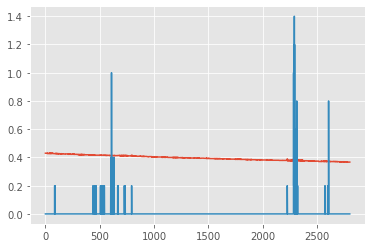

In [129]:
plt.plot(dataset)

In [130]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [131]:
# split into train and test sets
train_size  = int(len(dataset) * 0.75)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


2100 701


----------------- TRAINING DATA -----------------


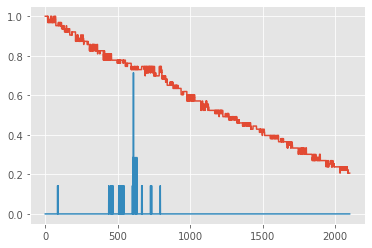

----------------- TEST DATA -----------------


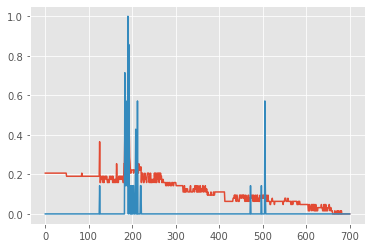

In [132]:
print('----------------- TRAINING DATA -----------------')
plt.plot(train)
plt.show()
print('----------------- TEST DATA -----------------')
plt.plot(test)
plt.show()

In [133]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), [0]]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 1])
    return np.array(dataX), np.array(dataY)


In [134]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [135]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [136]:
print(trainX)

[[[1.         1.         1.         ... 1.         1.         1.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]]

 [[1.         1.         1.         ... 1.         1.         1.        ]]

 ...

 [[0.22222233 0.2063489  0.22222233 ... 0.2063489  0.2063489  0.2063489 ]]

 [[0.2063489  0.22222233 0.2063489  ... 0.2063489  0.2063489  0.2063489 ]]

 [[0.22222233 0.2063489  0.2063489  ... 0.2063489  0.2063489  0.2063489 ]]]


In [137]:
#Setup the LSTM

model = tf.keras.Sequential()
model.add(LSTM(8, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=100, verbose=2)

Epoch 1/5
21/21 - 1s - loss: 0.0023
Epoch 2/5
21/21 - 0s - loss: 7.9870e-04
Epoch 3/5
21/21 - 0s - loss: 6.3976e-04
Epoch 4/5
21/21 - 0s - loss: 6.0788e-04
Epoch 5/5
21/21 - 0s - loss: 5.9211e-04


In [138]:
# Print out the evaluation for both the
#trainScore = model.evaluate(trainX[0.1], trainY, verbose=0)
#trainScore = math.sqrt(trainScore)
#trainScore = scaler.inverse_transform(np.array([[trainScore]]))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = model.evaluate(testX, testY, verbose=0)
#testScore = math.sqrt(testScore)
#testScore = scaler.inverse_transform(np.array([[testScore]]))
#print('Test Score: %.2f RMSE' % (testScore))

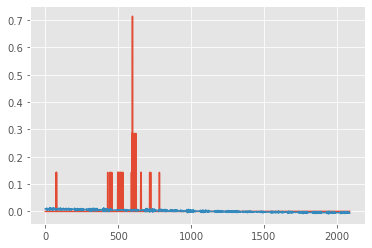

In [139]:
trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot       = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredict
 
# shift test predictions for plotting
testPredictPlot       = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredict
 
# plot baseline and predictions
plt.plot(trainY)
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.show()

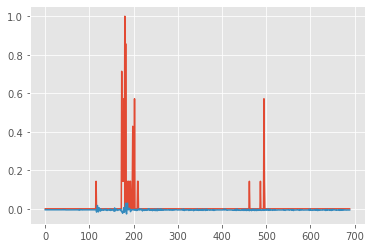

In [140]:
plt.plot(testY)
plt.plot(testPredict)

In [141]:
# Test the network on an unseen data
unseen = pandas.read_csv('dataset/flood_test.csv',sep=',')

NameError: name 'pandas' is not defined

In [ ]:
unseen.head()

,datetime,rainfall,waterlevel
0,1/1/2013 0:10,0.0,0.21
1,1/1/2013 0:21,0.0,0.21
2,1/1/2013 0:30,0.0,0.40
3,1/1/2013 1:30,0.0,0.49
4,1/1/2013 1:40,0.0,0.59


In [ ]:
unseen_test = unseen['waterlevel'].values

NameError: name 'unseen' is not defined

In [ ]:
plt.plot(unseen_test[0:20000])

NameError: name 'unseen_test' is not defined

In [ ]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

NameError: name 'unseen_test' is not defined

In [ ]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [ ]:
unseen_results = model.predict(features)

-------------------- Predicted --------------------


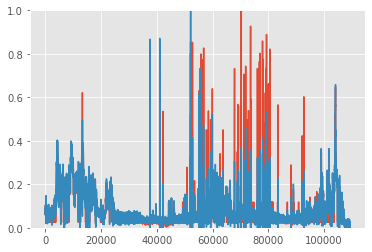

In [ ]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(labels)
plt.plot(unseen_results)
plt.show()

In [ ]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.16 RMSE


#### It seems that the network is having a hard time predicting higher flood level values
#### Checking the first 20000 data shows that the network is relatively comfortable on predicting ahead of time flood level values when the flood level  aren't extreme

----------------- Predicted ---------------


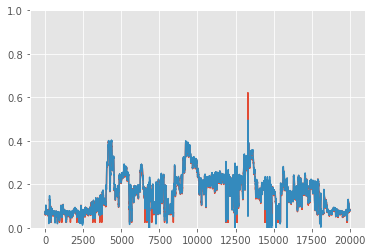

In [ ]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(labels[0:20000])
plt.plot(unseen_results[0:20000])
plt.show()
plt.show()